In [8]:
import numpy as np
import pandas as pd
import sys
from pathlib import Path
sys.path.append('..') 
# sys.path.append(r'C:\Users\zhixi\Documents\GitHub\aind-beh-ephys-analysis\code\beh_ephys_analysis')
import platform
import os
from pathlib import Path
import shutil
from pathlib import Path
import shutil
from utils.behavior.session_utils import load_session_df, parse_session_string
from utils.behavior.lick_analysis import clean_up_licks, parse_lick_trains
from scipy.io import loadmat
from itertools import chain
from matplotlib import pyplot as plt
from IPython.display import display
from scipy.signal import find_peaks
from harp.clock import align_timestamps_to_anchor_points
from utils.basics.data_org import *
from utils.photometry.preprocessing import * 
from utils.photometry.plot_utils import align_signal_to_events, color_gradient, plot_FP_with_licks, plot_G_vs_Iso, plot_FP_beh_analysis
import numpy as np
from scipy.signal import butter, filtfilt, medfilt, sosfiltfilt
from scipy.optimize import curve_fit
import json
from sklearn.linear_model import LinearRegression
from matplotlib.gridspec import GridSpec
import pickle
from aind_fip_dff.utils.preprocess import batch_processing, tc_triexpfit
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import time
from contextlib import redirect_stdout
from utils.ephys.plot_utils import plot_raster_rate, plot_rate, get_spike_matrix
# %matplotlib inline
# %matplotlib widget

In [2]:
session = 'm754896d20250109'
label = 'Gi'
session_dir = parse_session_string(session)
session_df, licks_L, licks_R = load_session_df(session)
licks_L, licks_R, fig = clean_up_licks(licks_L, licks_R, plot=False)
parsed_licks_L, _ = parse_lick_trains(licks_L)
parsed_licks_R, _ = parse_lick_trains(licks_R)
# signal_region = load_session_FP(session, label, plot=False);
# signal_region_raw = load_session_FP_raw(session, label, plot=False);
# signal_pre = preprocess_signal(session, label, fs = 20, lowcut = 0.1, fc = 9, xtol=1e-6, plot=True)

signal, params = get_FP_data(session)

Loaded m754896d20250109_combined.pkl and m754896d20250109_combined_params.pkl


Loaded m699461d20240105_combined.pkl and m699461d20240105_combined_params.pkl
Loaded m699461d20240105_combined.pkl and m699461d20240105_combined_params.pkl


KeyboardInterrupt: 

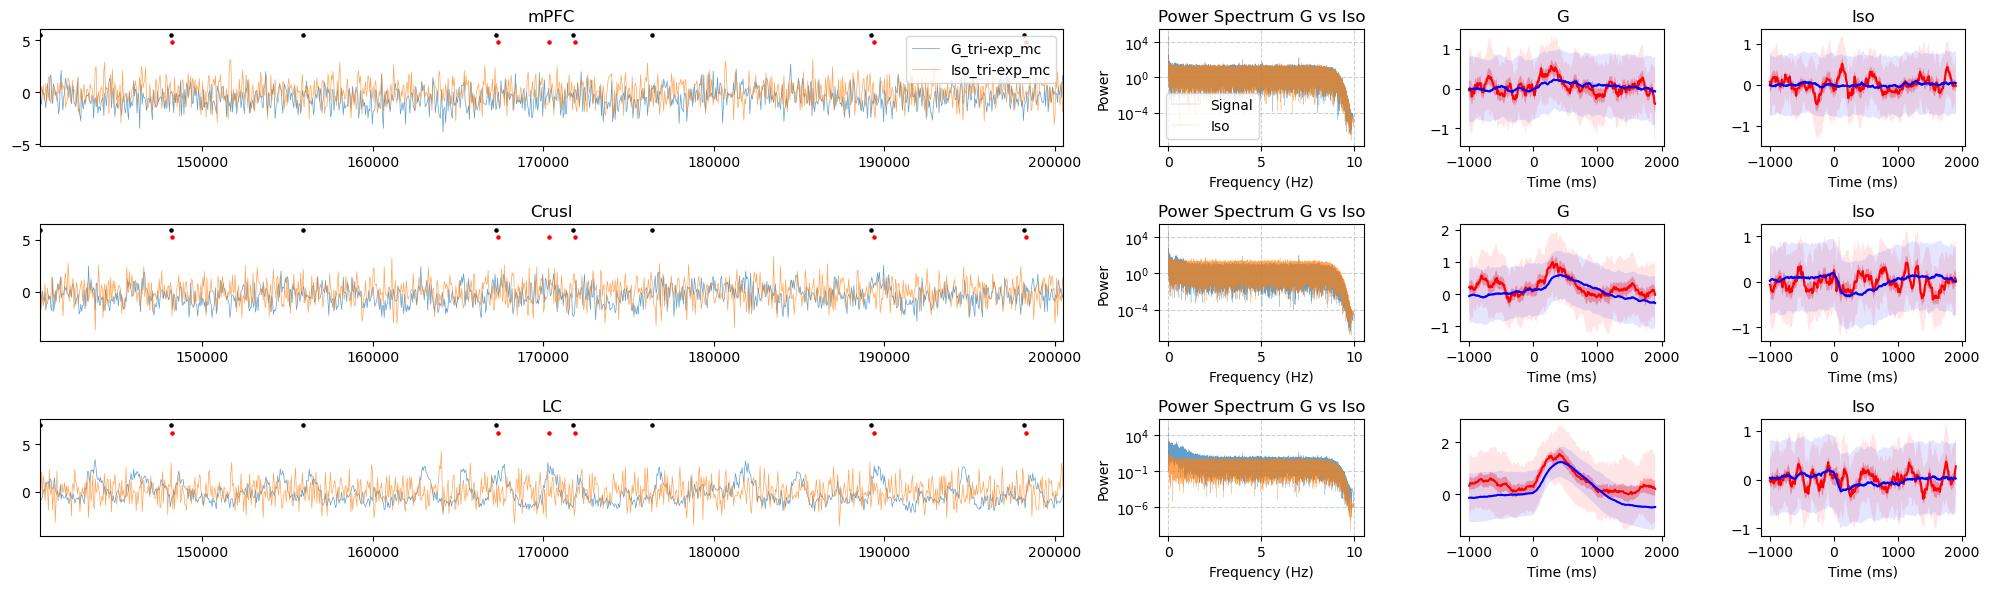

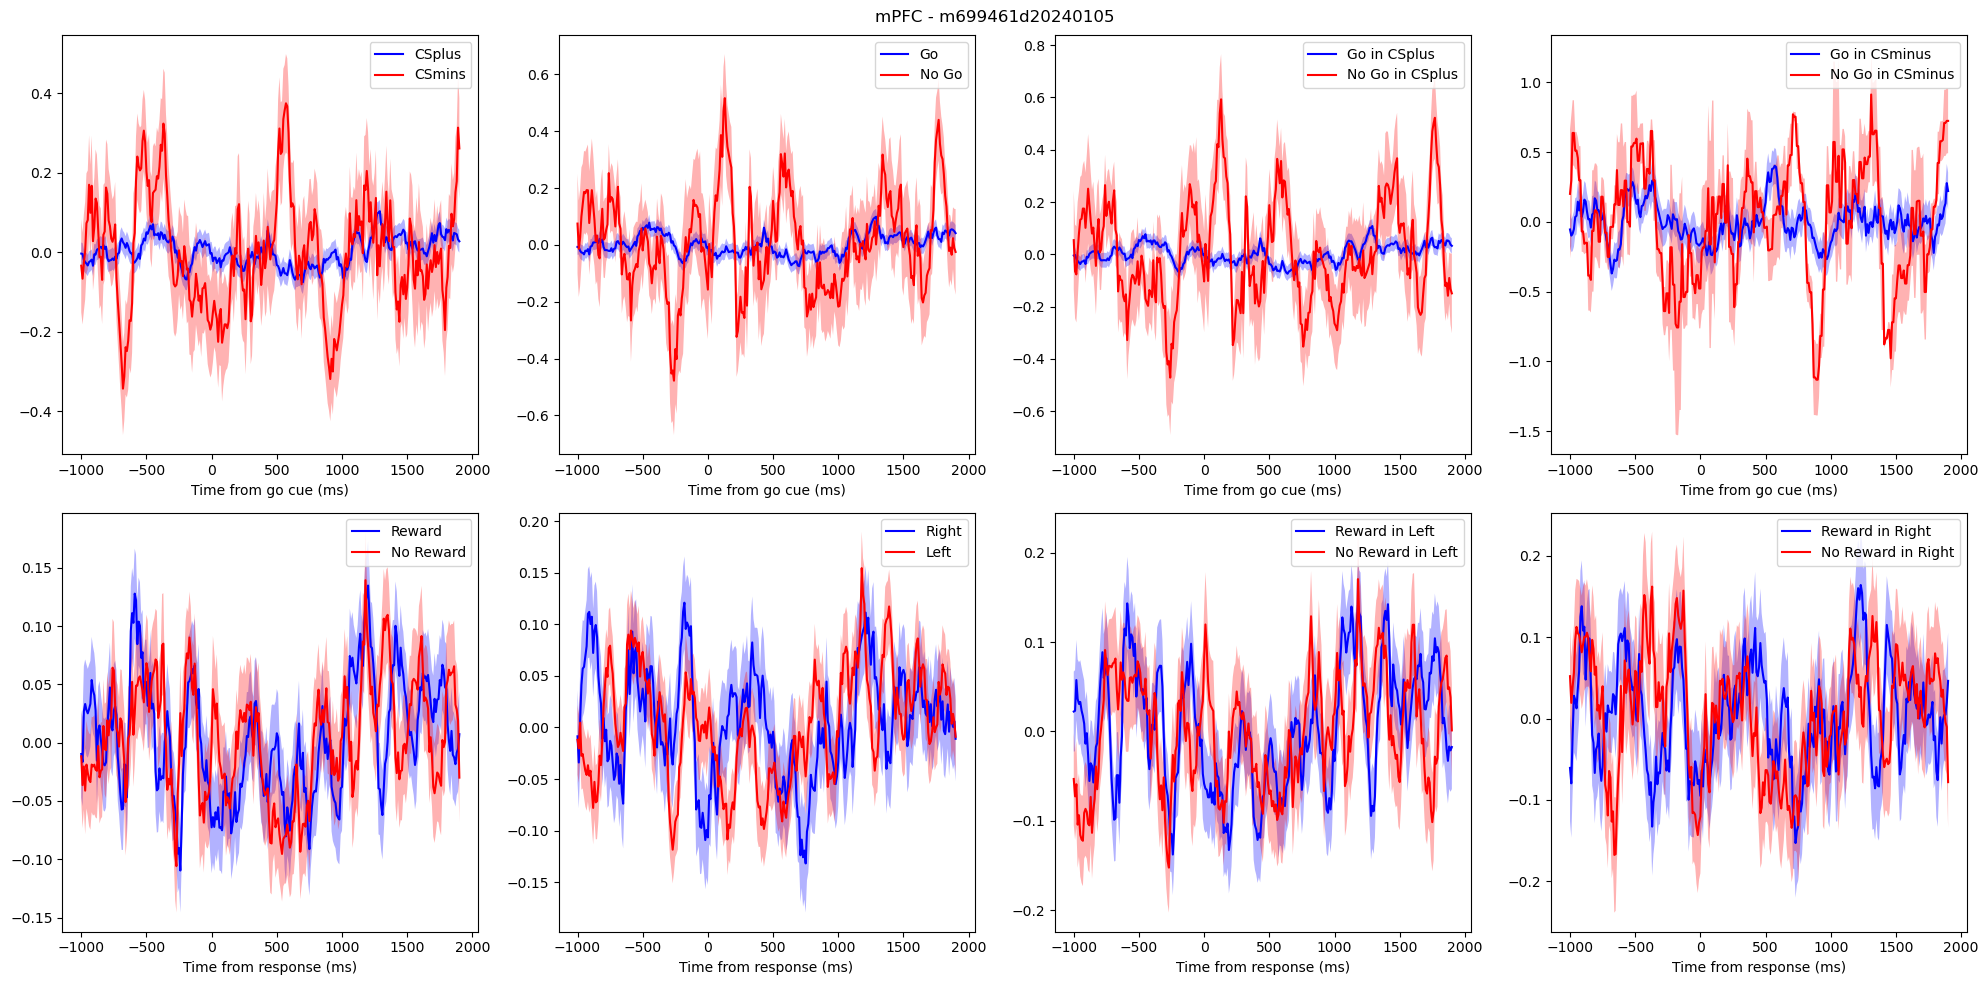

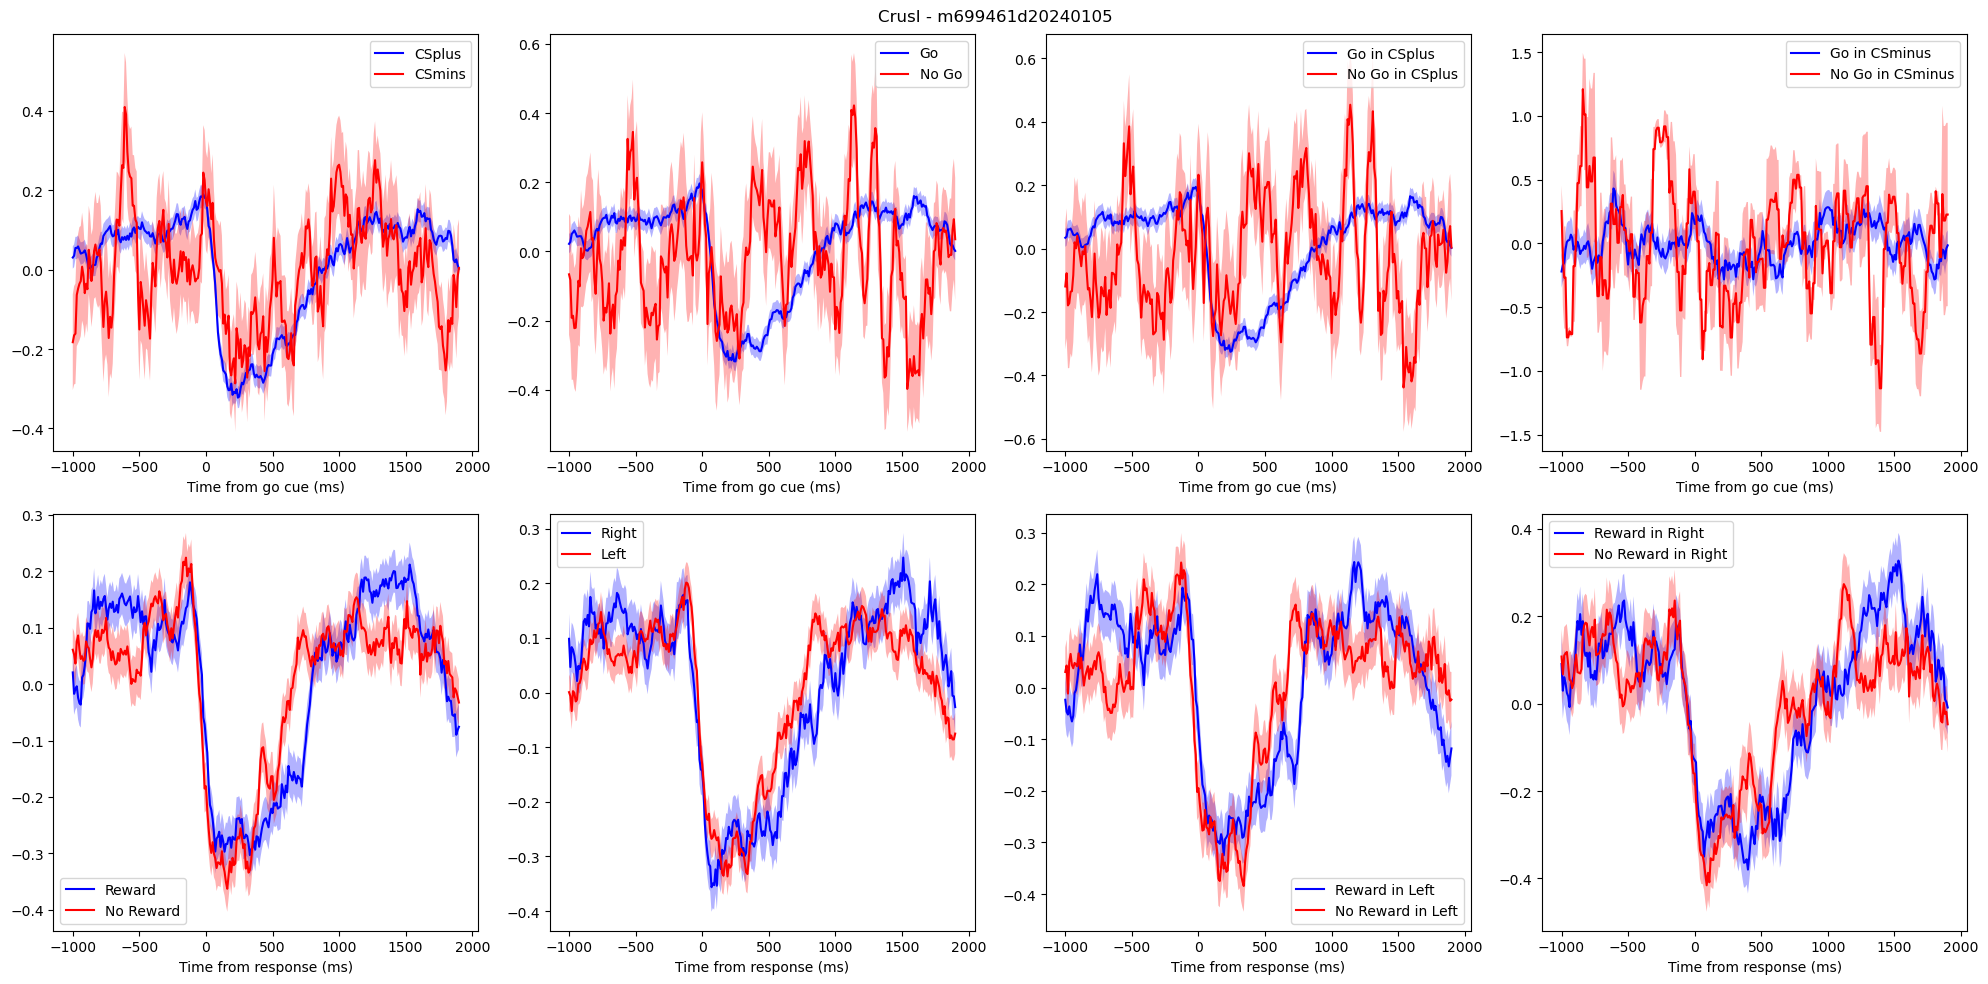

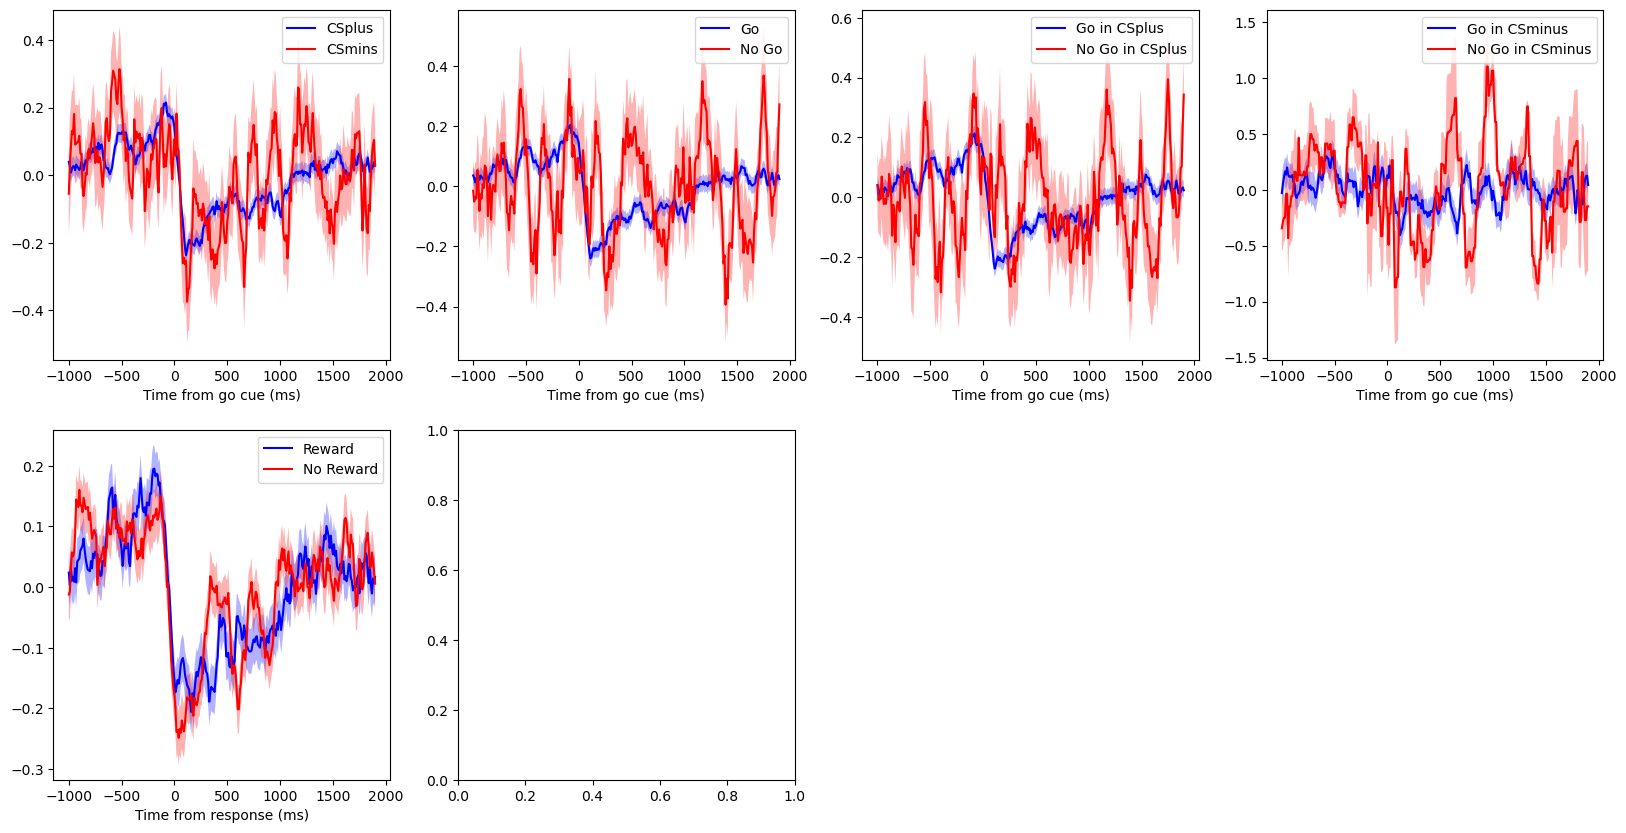

In [4]:
session = 'm699461d20240105'
fig = plot_G_vs_Iso(session)
plot_FP_beh_analysis(session, channel='Iso_tri-exp_mc')

In [31]:
session_list = get_session_list('photometry', 'all', 'crusIgood') + get_session_list('photometry_Gi', 'all', 'Gi_G8') + get_session_list('photometry', 'all', 'goodFPNewOnly')
label = 'G'

In [7]:
def process(session):
    print(session)
    # plot_G_vs_Iso(session)
    plot_FP_beh_analysis(session, channel='G_tri-exp_mc')
    plot_FP_beh_analysis(session, channel='Iso_tri-exp_mc')
    plt.close('all')
    return

Parallel(n_jobs=8)(delayed(process)(session) for session in session_list)
plt.close('all')

In [32]:
def process(session):
    print(session)
    try:
        # plot_G_vs_Iso(session)
        # plot_FP_beh_analysis(session)
        plot_FP_peaks_behavior(session)
        plt.close('all')
    except:
        print(f"Error processing session {session}")
        plt.close('all')
        # Optionally, you can log the error or save it to a file
    return

Parallel(n_jobs=8)(delayed(process)(session) for session in session_list)
plt.close('all')

In [3]:
def correlate_nan(x, y, lag='full'):
    """Calculate correlation while ignoring NaNs."""
    if lag == 'full':
        lag = len(x) - 1
    corrs = np.full((lag + 1,), np.nan)
    for l in range(lag + 1):
        if l==0:
            valid_mask = ~np.isnan(x) & ~np.isnan(y)
            corrs[l] = np.corrcoef(x[valid_mask], y[valid_mask])[0, 1]
        else:
            valid_mask = ~np.isnan(x[:-l]) & ~np.isnan(y[l:])
            if np.any(valid_mask):
                corrs[l] = np.corrcoef(x[:-l][valid_mask], y[l:][valid_mask])[0, 1]
    return corrs

Loaded m754896d20250109_combined.pkl and m754896d20250109_combined_params.pkl
Loaded m754896d20250109_combined.pkl and m754896d20250109_combined_params.pkl


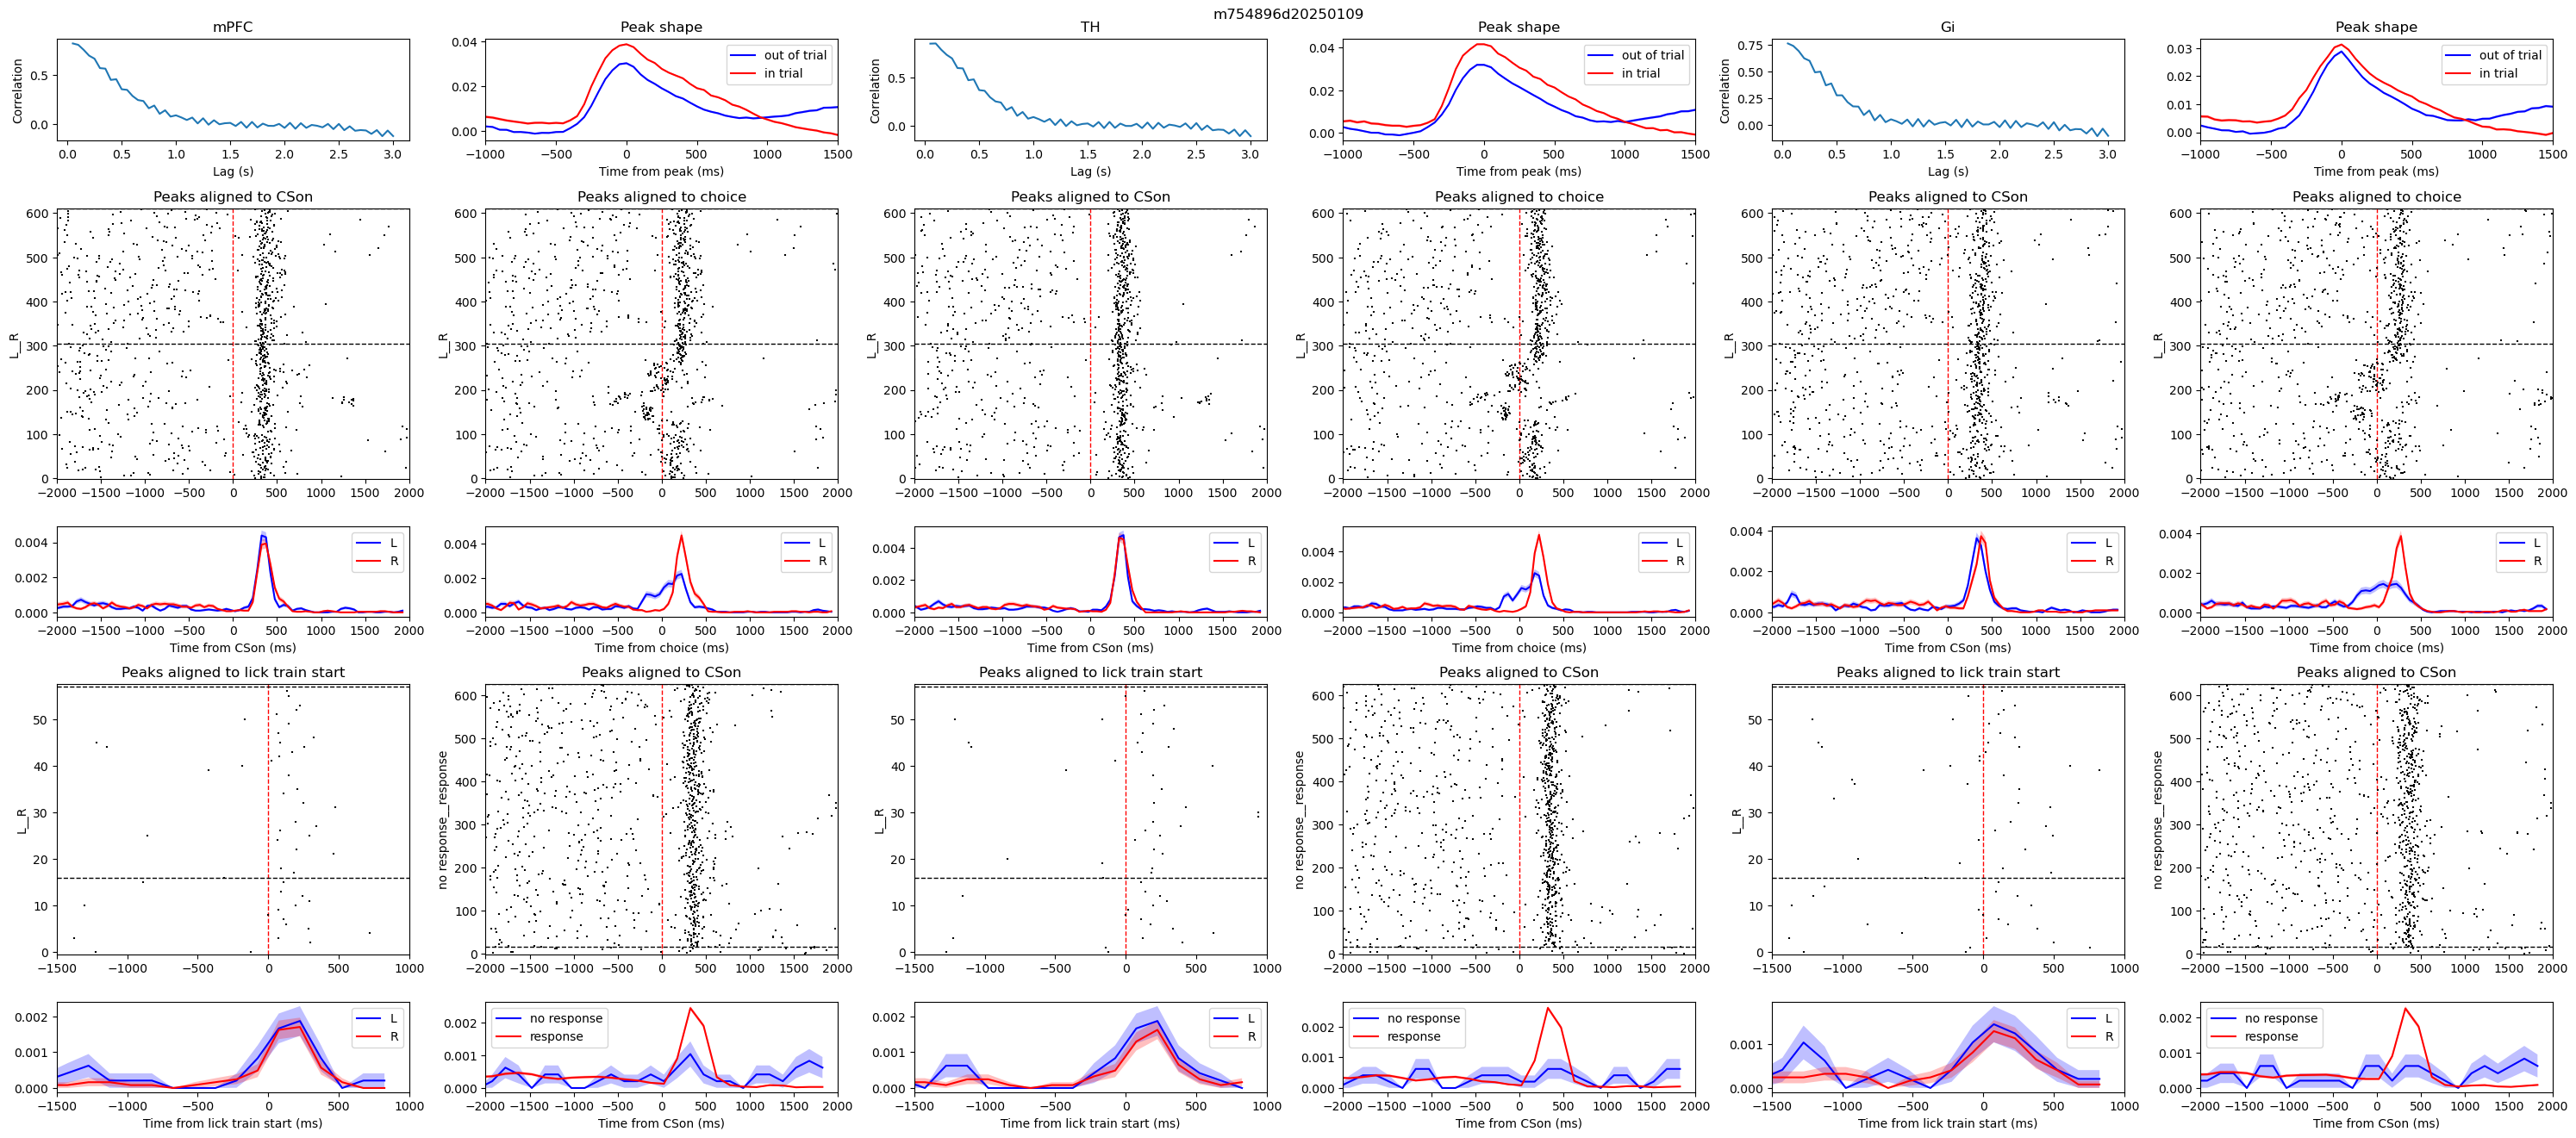

In [ ]:
def plot_FP_peaks_behavior(session):
    bin_size  = 0.05
    time_len = 3
    lags = int(np.floor(time_len/bin_size))
    acf_lags = np.arange(0, lags+1) * bin_size
    session_dir = parse_session_string(session)
    session_df, licks_L, licks_R = load_session_df(session)
    licks_L, licks_R, fig = clean_up_licks(licks_L, licks_R, plot=False)
    parsed_licks_L, _ = parse_lick_trains(licks_L)
    parsed_licks_R, _ = parse_lick_trains(licks_R)
    signal, params = get_FP_data(session)
    time = signal['time_in_beh']
    peaks = peak_detect_FP(session)
    targets = list(signal['G'].keys())
    colors = ["blue", "white", "red"]
    custom_cmap = LinearSegmentedColormap.from_list("blue_white_red", colors)

    fig = plt.figure(figsize=(30, 15))
    gs = GridSpec(4, 2*len(targets), figure=fig, height_ratios=[0.5, 2, 2, 0.5])
    for ind_tar in range(len(targets)):
        target = targets[ind_tar]
        channel = 'G_tri-exp_mc'
        signal_curr = signal[channel][target]
        peaks_curr = peaks['peak_time'][target]
        # auto_corr
        acf_bins = np.arange(time[0], time[-1], bin_size)
        signal_curr_acf = signal_curr
        # for i in range(acf_bins.shape[0]-1):
        #     signal_curr_acf[i] = np.mean(signal_curr[(time >= acf_bins[i]) & (time < acf_bins[i+1])])
        # # calculate autocorrelation
        acf = correlate_nan(signal_curr_acf, signal_curr_acf, lag=lags)
        acf = acf / acf[0]  # normalize by the first value

        ax = fig.add_subplot(gs[0, ind_tar*2])
        ax.plot(acf_lags[1:], acf[1:], label=target, color='C0')
        ax.set_title(f'{target}')
        ax.set_xlabel('Lag (s)')
        ax.set_ylabel('Correlation')

        # peak shape
        pre_event = -1000
        post_event = 1000
        binSize = 50  # ms
        stepSize = 50  # ms
        align_time = peaks_curr
        slide_times = np.arange(pre_event, post_event + stepSize, stepSize)
        currArray = np.zeros((len(align_time), len(slide_times)))
        for i, event in enumerate(align_time):
            for j, t in enumerate(slide_times):
                t_curr = event + t
                ind = np.where((time >= t_curr-0.5*binSize) & (time < t_curr + 0.5*binSize))[0]
                if len(ind) > 0:
                    currArray[i, j] = np.mean(signal_curr[ind])

        in_trial = np.full(len(peaks_curr), 0)
        go_cues = session_df['CSon'].values

        # remove licks that are following a go cue within 1 second
        for i in range(len(go_cues)):
            ind = np.where((peaks_curr> go_cues[i]) & (peaks_curr < go_cues[i] + 1000))[0]
            in_trial[ind] = 1
        map_value = in_trial
        bins = np.linspace(np.min(map_value), np.max(map_value), 3)  # bins for histogram
        bins[0] = bins[0] - 0.0001
        bins[-1] = bins[-1] + 0.0001
        labels = ['out of trial', 'in trial']
        fig, ax = plot_rate(
                            currArray,
                            slide_times, 
                            map_value,
                            bins,
                            labels,
                            custom_cmap,
                            fig,
                            gs[0, ind_tar*2+1],
                            pre_event,
                            post_event,
                        )
        ax.set_xlabel('Time from peak (ms)')
        ax.set_title('Peak shape')


        pre_event = -1000
        post_event = 1500
        time_bin = 100  # ms


        # peak detection aligned to go cue
        lick_lat = session_df['respondTime'].values - session_df['CSon'].values 
        lick_lat = lick_lat[session_df['rewardL'].notna() | session_df['rewardR'].notna()]
        lick_ind = np.argsort(lick_lat)
        focus_values = np.full(len(session_df), np.nan)
        focus_values[session_df['rewardR'].notna()] = 1
        focus_values[session_df['rewardL'].notna()] = 0
        focus_values = focus_values[~np.isnan(focus_values)]

        align_time = session_df[session_df['rewardL'].notna() | session_df['rewardR'].notna()]['CSon'].values
        bin_counts = 2
        bins= np.linspace(np.min(focus_values), np.max(focus_values), bin_counts + 1)  # bins for histogram

        bins[0] = bins[0] - 0.0001
        bins[-1] = bins[-1] + 0.0001
        labels = ['L', 'R']
        fig, ax1, ax2 = plot_raster_rate(peaks_curr,
                                        align_time[lick_ind], 
                                        focus_values[lick_ind], # sorted by certain value
                                        bins,
                                        labels,
                                        custom_cmap,
                                        fig,
                                        gs[1, ind_tar*2:ind_tar*2+1],
                                        tb=pre_event,
                                        tf=post_event,
                                        time_bin=time_bin,
                                        )
        ax2.set_xlabel('Time from CSon (ms)')
        ax2.set_title('')
        ax1.set_title('Peaks aligned to CSon')
        # peak detection aligned to response

        align_time = session_df[session_df['rewardL'].notna() | session_df['rewardR'].notna()]['respondTime'].values
        bin_counts = 2
        bins= np.linspace(np.min(focus_values), np.max(focus_values), bin_counts + 1)  # bins for histogram

        bins[0] = bins[0] - 0.0001
        bins[-1] = bins[-1] + 0.0001
        labels = ['L', 'R']
        fig, ax1, ax2 = plot_raster_rate(peaks_curr,
                                        align_time[lick_ind], 
                                        focus_values[lick_ind], # sorted by certain value
                                        bins,
                                        labels,
                                        custom_cmap,
                                        fig,
                                        gs[1, ind_tar*2+1],
                                        tb=pre_event,
                                        tf=post_event,
                                        time_bin=time_bin,
                                        )
        ax2.set_xlabel('Time from choice (ms)')
        ax2.set_title('')
        ax1.set_title('Peaks aligned to choice')

        # aligned to lick starts
        pre_event = -1000
        post_event = 1500
        time_bin = 300  # ms

        L_licks = parsed_licks_L['train_starts']
        R_licks = parsed_licks_R['train_starts']
        go_cues = session_df['CSon'].values
        peaks_curr_iti = peaks_curr.copy()
        # remove licks that are following a go cue within 1 second
        for i in range(len(go_cues)):
            L_licks = np.delete(L_licks, np.where((L_licks > go_cues[i]) & (L_licks < go_cues[i] + 1000))[0])
            R_licks = np.delete(R_licks, np.where((R_licks > go_cues[i]) & (R_licks < go_cues[i] + 1000))[0])
            peaks_curr_iti = np.delete(peaks_curr_iti, np.where((peaks_curr_iti > go_cues[i]) & (peaks_curr_iti < go_cues[i] + 1000))[0])
        all_licks = np.concatenate((L_licks, R_licks))
        focus_values = np.concatenate((np.zeros(len(L_licks)), np.ones(len(R_licks))))


        align_time = all_licks
        bin_counts = 2
        bins= np.linspace(np.min(focus_values), np.max(focus_values), bin_counts + 1)  # bins for histogram

        bins[0] = bins[0] - 0.0001
        bins[-1] = bins[-1] + 0.0001
        labels = ['L', 'R']
        fig, ax1, ax2 = plot_raster_rate(peaks_curr_iti,
                                        align_time, 
                                        focus_values, # sorted by certain value
                                        bins,
                                        labels,
                                            custom_cmap,
                                            fig,
                                            gs[2, ind_tar*2],
                                            tb=pre_event,
                                            tf=post_event,
                                            time_bin=time_bin,
                                            )
        ax2.set_xlabel('Time from lick train start (ms)')
        ax2.set_title('')
        ax1.set_title('Peaks aligned to lick train start')


        pre_event = -1000
        post_event = 1500
        time_bin = 300  # ms
        align_time = session_df['CSon'].values
        focus_values = session_df['rewardR'].notna() | session_df['rewardL'].notna()
        bin_counts = 2
        bins= np.linspace(np.min(focus_values), np.max(focus_values), bin_counts + 1)  # bins for histogram
        bins[0] = bins[0] - 0.0001
        bins[-1] = bins[-1] + 0.0001
        labels = ['no response', 'response']
        fig, ax1, ax2 = plot_raster_rate(peaks_curr,
                                        align_time, 
                                        focus_values, # sorted by certain value
                                        bins,
                                        labels,
                                        custom_cmap,
                                        fig,
                                        gs[2, ind_tar*2+1],
                                        tb=pre_event,
                                        tf=post_event,
                                        time_bin=time_bin,
                                        )
        ax1.set_ylim(-0.5, len(align_time) + 0.5)
        ax2.set_xlabel('Time from CSon (ms)')
        ax2.set_title('')
        ax2.legend(loc='upper left')
        ax1.set_title('Peaks aligned to CSon')

    plt.suptitle(session)
    plt.tight_layout()
    plt.savefig(os.path.join(session_dir['saveFigFolder'], 'FP_peaks_behavior.pdf'))

session = 'm754896d20250109'
plot_FP_peaks_behavior(session)